# MNIST dataset
> <span style="color:gray">
Original [Theano/Lasagne tutorial](https://github.com/DeepLearningDTU/nvidia_deep_learning_summercamp_2016/blob/master/lab1/lab1_FFN.ipynb) by 
Lars Maaløe ([larsmaaloee](https://github.com/larsmaaloee)),
Søren Kaae Sønderby ([skaae](https://github.com/skaae)), and 
Casper Sønderby ([casperkaae](https://github.com/casperkaae)). 
Converted to TensorFlow by 
Alexander R. Johansen ([alrojo](https://github.com/alrojo)), 
and updated by 
Toke Faurby ([faur](https://github.com/Faur)) and 
Mikkel Vilstrup ([mvilstrup](https://github.com/MVilstrup)).
</span>

In this notebook we will guide you through building a neural network classifier for the (in)famous MNIST dataset.
MNIST is a dataset that is often used for benchmarking, consisting of 70.000 image-label paris of handwritten digits from 0-9.
During the notebook we have provided a program skeleton and severalt tips to help guid you through it.
Further more the task is quite similar to what you did in the previous notebook, so you should reffer to it in order to remind yourself about the implementation.

Along the way you will also learn about 
* selecting nonlinearity, and
* stochastic gradient descent with mini-batches.

We will implement a dense feedforward neural network (just like before).
In this setting we represent each image as a vector, instead of a 2D map.
We therefore lose the spatial information of the images.
The ordering of the pixels in the vector does not matter, so we could permutate all images using the same permutation and still get the same performance.
This task is therefore called the _permutation invariant_ MNIST.
Obviously this throws away a lot of structure in the data that could have been used.
Later we will see how spatial information can be included, by using the convolutional neural network architecture.


## Implementation Rules

In this exercise we want you to get some experience with setting up training for yourself, and we therefore want you to implement the training loop yourself.
You are therefore **NOT** allowed to use the `keras.models.Sequential.fit` function.
The `Sequential` model, or built in layers, such as `keras.layers.Dense` are allowed, as long as you define the training ops and training loop yourself.
(If are having problems using `keras.layers` have a look at the [Keras as a simplified interface to TensorFlow](https://blog.keras.io/keras-as-a-simplified-interface-to-tensorflow-tutorial.html) tutorial).


In [3]:
from __future__ import absolute_import, division, print_function 

import os
import sys
sys.path.append(os.path.join('.', '..')) 
import utils
import tensorflow as tf
import numpy as np

from sklearn.metrics import confusion_matrix

%matplotlib inline
import matplotlib.pyplot as plt

## The MNIST dataset
The 70,000 images-label pairs are split into a 
* 55,000 images training set, 
* 5,000 images validation set and 
* 10,000 images test set.

The images are 28x28 pixels, where each pixel represents the light intensity normalised value between 0-1 (0=black, 1=white).
The number of features is therefore 28x28=784.

First let's load the MNIST dataset and plot a few examples. TensorFlow has a [convenient MNIST interface](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/learn/python/learn/datasets/mnist.py) that we will use to download and manage the data.

In [4]:
# Load data (download if you haven't already)
from tensorflow.examples.tutorials.mnist import input_data
mnist_data = input_data.read_data_sets('MNIST_data', 
                                       one_hot=True,   # Convert the labels into one hot encoding
                                       dtype='float32' # rescale images to `[0, 1]`
                                      )

Extracting MNIST_data\train-images-idx3-ubyte.gz
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz


Information on dataset
----------------------
Training size:	 55000
Test size	 10000
Validation size	 5000

Data summaries
Image shape		 784
Image type		 <class 'numpy.float32'>
Image min/max value	 0.0 / 1.0
Label shape		 10
Label type		 <class 'numpy.float64'>


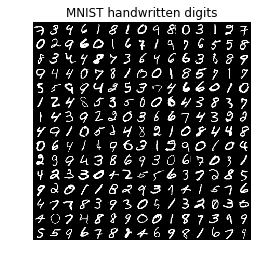

In [5]:
## Print dataset statistics and visualize
print("""Information on dataset
----------------------""")
print("Training size:\t", mnist_data.train.num_examples)
print("Test size\t", mnist_data.test.num_examples)
print("Validation size\t", mnist_data.validation.num_examples)

num_features = mnist_data.train.images[0].shape[0]
num_classes = mnist_data.train.labels[0].shape[0]

print('\nData summaries')
print("Image shape\t\t", num_features)
print("Image type\t\t", type(mnist_data.train.images[0][0]))
print("Image min/max value\t", np.min(mnist_data.train.images), '/', np.max(mnist_data.train.images))
print("Label shape\t\t", num_classes)
print("Label type\t\t", type(mnist_data.train.labels[0][0]))


## Plot a few MNIST examples
img_to_show = 15
idx = 0
canvas = np.zeros((28*img_to_show, img_to_show*28))
for i in range(img_to_show):
    for j in range(img_to_show):
        canvas[i*28:(i+1)*28, j*28:(j+1)*28] = mnist_data.train.images[idx].reshape((28, 28))
        idx += 1
plt.figure(figsize=(4,4))
plt.axis('off')
plt.imshow(canvas, cmap='gray')
plt.title('MNIST handwritten digits')
plt.show()


## Creating the graph

#### <span style="color:red"> EXE 1) Defining the network
</span>

In the cell below, at the place that says `### YOUR CODE HERE ###` implement the following:

* Define two layers. Remember to give them proper names.
    * Try some different nonlinearities, and compare their performance
* The non-linearity of the output layer should be softmax ([tf.nn.softmax](https://www.tensorflow.org/api_docs/python/tf/nn/softmax))


Here, I define a neural network with a thousand units in the hidden layer. 
I will do the comparison with different nonlinearities later, when we have trained our first network.

In [6]:
## Build the network
tf.reset_default_graph()

## Define placeholders
x_pl = tf.placeholder(tf.float32, [None, num_features], name='xPlaceholder')
y_pl = tf.placeholder(tf.float32, [None, num_classes], name='yPlaceholder')

## Define the model

### YOUR CODE HERE ###

n_hidden1 = 1000 # Number of neurons in the hidden layer.
stddev=0.001

# definition of weights and biases

weights = {
    'h1': tf.Variable(tf.random_normal([num_features, n_hidden1], stddev=stddev)),
    'out': tf.Variable(tf.random_normal([n_hidden1, num_classes], stddev=stddev))
}
biases = {
    'b1': tf.Variable(tf.random_normal([n_hidden1])),
    'out': tf.Variable(tf.random_normal([num_classes]))
}

with tf.variable_scope('model'):
    layer_1 = tf.nn.relu(tf.add(tf.matmul(x_pl, weights['h1']), biases['b1']))     
    y = tf.nn.softmax(tf.add(tf.matmul(layer_1, weights['out']), biases['out']))

#### <span style="color:red"> EXE 2) Defining the training operations.
</span>

In the cell below, at the place that says `### YOUR CODE HERE ###` implement the following:

* Cross_entropy loss
* An optimizer and training op
* An op computing the accuracy

Here I define the training ops. I use the Adam optimizer.

In [7]:
### Implement training ops

with tf.variable_scope('loss'):
    cross_entropy = -tf.reduce_sum(y_pl * tf.log(y), reduction_indices=[1])
    cross_entropy = tf.reduce_mean(cross_entropy)

with tf.variable_scope('trainOP'):
    train_op = tf.train.AdamOptimizer(learning_rate=0.01).minimize(cross_entropy)     

with tf.variable_scope('performance'):
    correct_prediction = tf.equal(tf.argmax(y, axis=1), tf.argmax(y_pl, axis=1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# Add saver op to restore the model for prediction  
saver = tf.train.Saver()

In [8]:
# defining a function to make predictions using our classifier (for later)
def pred(X_in, sess):
    # first we must define what data to give it
    feed_dict = {x_pl: X_in}
    # secondly our fetches
    fetches = [y]
    # utilizing the given session (ref. sess) to compute results
    res = sess.run(fetches, feed_dict)
    # res is a list with each indices representing the corresponding element in fetches
    return res[0]

### Stochastic gradient descent with mini-batches

In the last notebook we used the entire dataset to compute every parameter update.
For large datasets this is very costly and inefficient.
Instead we can compute the gradient on only a small subset of the data, a *mini-batches*, and use it to update the parameters.
Bath size varies a lot depending on application but between 8-256 is common.
Bigger is not allways better.
With smaller mini-batch size you get more updates and your model might converge faster.
Also small batchsizes uses less memory -> freeing up memory so you train a model with more parameters.

#### <span style="color:red"> EXE 3) Testing the forward pass
</span>

Before building the training loop lets ensure that the forward pass works.

In the cell below, at the place that says `### YOUR CODE HERE ###` implement the following:

* define the `feed_dict`
* pass `x` through the network using `sess.run`

In [13]:
#Test the forward pass
batch_size = 32

# Get a mini-batch
x_tr, y_tr = mnist_data.train.next_batch(batch_size)

# Restricting memory usage, TensorFlow is greedy and will use all memory otherwise
with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    
    ### YOUR CODE HERE ###
    feed_dict = {x_pl: x_tr}
    fetches = y
    y_pred = sess.run(fetches, feed_dict)    

# I have changed the name of the training labels to y_tr.    
    
assert y_pred.shape == y_tr.shape, "ERROR the output shape is not as expected!" \
        + " Output shape should be " + str(y_tr.shape) + ' but was ' + str(y_pred.shape)

# Build the training loop.
We train the network by calculating the gradient w.r.t the cost function and update the parameters in direction of the negative gradient. 


When training neural network you always use mini batches.
Instead of calculating the average gradient using the entire dataset you approximate the gradient using a mini-batch of typically 16 to 256 samples.
The paramters are updated after each mini batch.
Networks converges much faster using minibatches because the paramters are updated more often.



#### <span style="color:red"> EXE 4) Building the training loop.
</span>

In the cell below, at the place that says `### YOUR CODE HERE ###` implement the following:

* Perform the training operation
* Collect training statistics
* [Optional] Monitor training in TensorBoard.

We now train 3 different neural networks, first we use the relu activation function, then tanh and finally elu.

In [14]:
max_epochs = 1000
batch_size = 32

# restricting memory usage, TensorFlow is greedy and will use all memory otherwise
gpu_opts = tf.GPUOptions(per_process_gpu_memory_fraction=0.2)

train_cost, val_cost, train_acc, val_acc = [],[],[],[]
with tf.Session(config=tf.ConfigProto(gpu_options=gpu_opts)) as sess:    
    try:
        sess.run(tf.global_variables_initializer())

        for e in range(max_epochs):
        
        #while mnist_data.train.epochs_completed < max_epochs:
            # Load one mini-batch
            x_tr, y_tr = mnist_data.train.next_batch(batch_size)
            
            ### YOUR CODE HERE ###
            # 1) Run the train op
            
            feed_dict_train = {x_pl: x_tr, y_pl: y_tr}            
            fetches_train = [train_op, cross_entropy, accuracy]
            res = sess.run(fetches=fetches_train, feed_dict=feed_dict_train)
      
            # 2) Compute train_cost, val_cost, train_acc, val_acc
        
            # storing cross entropy (second fetch argument, so index=1)
            train_cost += [res[1]]
            train_acc += [res[2]]              
        
            feed_dict_valid = {x_pl: mnist_data.validation.images, y_pl: mnist_data.validation.labels}

            # deciding which parts to fetch
            fetches_valid = [cross_entropy, accuracy]          
            
            # running the validation
            res = sess.run(fetches=fetches_valid, feed_dict=feed_dict_valid)
            val_cost += [res[0]]
            val_acc += [res[1]]            
                      
            # 3) Print training summaries
            
            if e % 100 == 0:
                print("Epoch %i, Train Cost: %0.3f\tVal Cost: %0.3f\t Val acc: %0.3f" \
                      %(e, train_cost[-1],val_cost[-1],val_acc[-1]))
                
        # Retrieve the weights
        #weights1 = W_1.eval()
        #biases1 = b_1.eval()
        
        #weights2 = W_2.eval()
        #biases2 = b_2.eval() 
        
        saver.save(sess, './mnist_network_relu')
        
    except KeyboardInterrupt:
        print('KeyboardInterrupt')

print('Done')

Epoch 0, Train Cost: 2.600	Val Cost: 5.814	 Val acc: 0.174
Epoch 100, Train Cost: 0.464	Val Cost: 0.418	 Val acc: 0.880
Epoch 200, Train Cost: 0.638	Val Cost: 0.307	 Val acc: 0.910
Epoch 300, Train Cost: 0.372	Val Cost: 0.291	 Val acc: 0.909
Epoch 400, Train Cost: 1.033	Val Cost: 0.266	 Val acc: 0.923
Epoch 500, Train Cost: 0.211	Val Cost: 0.271	 Val acc: 0.924
Epoch 600, Train Cost: 0.162	Val Cost: 0.210	 Val acc: 0.940
Epoch 700, Train Cost: 0.525	Val Cost: 0.269	 Val acc: 0.925
Epoch 800, Train Cost: 0.311	Val Cost: 0.264	 Val acc: 0.926
Epoch 900, Train Cost: 0.122	Val Cost: 0.229	 Val acc: 0.936
Done


We can then try with tanh.

In [15]:
## Build the network
tf.reset_default_graph()

## Define placeholders
x_pl = tf.placeholder(tf.float32, [None, num_features], name='xPlaceholder')
y_pl = tf.placeholder(tf.float32, [None, num_classes], name='yPlaceholder')

## Define the model

### YOUR CODE HERE ###

n_hidden1 = 1000 # Number of neurons in the hidden layer.
stddev=0.001

# definition of weights and biases

weights = {
    'h1': tf.Variable(tf.random_normal([num_features, n_hidden1], stddev=stddev)),
    'out': tf.Variable(tf.random_normal([n_hidden1, num_classes], stddev=stddev))
}
biases = {
    'b1': tf.Variable(tf.random_normal([n_hidden1])),
    'out': tf.Variable(tf.random_normal([num_classes]))
}

with tf.variable_scope('model'):
    layer_1 = tf.nn.tanh(tf.add(tf.matmul(x_pl, weights['h1']), biases['b1']))     
    y = tf.nn.softmax(tf.add(tf.matmul(layer_1, weights['out']), biases['out']))

with tf.variable_scope('loss'):
    cross_entropy = -tf.reduce_sum(y_pl * tf.log(y), reduction_indices=[1])
    cross_entropy = tf.reduce_mean(cross_entropy)

with tf.variable_scope('trainOP'):
    train_op = tf.train.AdamOptimizer(learning_rate=0.001).minimize(cross_entropy)     

with tf.variable_scope('performance'):
    correct_prediction = tf.equal(tf.argmax(y, axis=1), tf.argmax(y_pl, axis=1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# Add saver op    
saver = tf.train.Saver()

In [16]:
# restricting memory usage, TensorFlow is greedy and will use all memory otherwise
gpu_opts = tf.GPUOptions(per_process_gpu_memory_fraction=0.2)

train_cost, val_cost, train_acc, val_acc = [],[],[],[]
with tf.Session(config=tf.ConfigProto(gpu_options=gpu_opts)) as sess:    
    try:
        sess.run(tf.global_variables_initializer())

        for e in range(max_epochs):
        
        #while mnist_data.train.epochs_completed < max_epochs:
            # Load one mini-batch
            x_tr, y_tr = mnist_data.train.next_batch(batch_size)
            
            ### YOUR CODE HERE ###
            # 1) Run the train op
            
            feed_dict_train = {x_pl: x_tr, y_pl: y_tr}            
            fetches_train = [train_op, cross_entropy, accuracy]
            res = sess.run(fetches=fetches_train, feed_dict=feed_dict_train)
      
            # 2) Compute train_cost, val_cost, train_acc, val_acc
        
            # storing cross entropy (second fetch argument, so index=1)
            train_cost += [res[1]]
            train_acc += [res[2]]              
        
            feed_dict_valid = {x_pl: mnist_data.validation.images, y_pl: mnist_data.validation.labels}

            # deciding which parts to fetch
            fetches_valid = [cross_entropy, accuracy]          
            
            # running the validation
            res = sess.run(fetches=fetches_valid, feed_dict=feed_dict_valid)
            val_cost += [res[0]]
            val_acc += [res[1]]            
                      
            # 3) Print training summaries
            
            if e % 100 == 0:
                print("Epoch %i, Train Cost: %0.3f\tVal Cost: %0.3f\t Val acc: %0.3f" \
                      %(e, train_cost[-1],val_cost[-1],val_acc[-1]))
        
        saver.save(sess, './mnist_network_tanh')
        
    except KeyboardInterrupt:
        print('KeyboardInterrupt')

print('Done')

Epoch 0, Train Cost: 2.632	Val Cost: 2.460	 Val acc: 0.092
Epoch 100, Train Cost: 0.518	Val Cost: 0.436	 Val acc: 0.868
Epoch 200, Train Cost: 0.512	Val Cost: 0.388	 Val acc: 0.873
Epoch 300, Train Cost: 0.639	Val Cost: 0.302	 Val acc: 0.905
Epoch 400, Train Cost: 0.208	Val Cost: 0.290	 Val acc: 0.913
Epoch 500, Train Cost: 0.234	Val Cost: 0.253	 Val acc: 0.928
Epoch 600, Train Cost: 0.164	Val Cost: 0.251	 Val acc: 0.924
Epoch 700, Train Cost: 0.158	Val Cost: 0.225	 Val acc: 0.931
Epoch 800, Train Cost: 0.273	Val Cost: 0.224	 Val acc: 0.935
Epoch 900, Train Cost: 0.138	Val Cost: 0.216	 Val acc: 0.935
Done


We could then try a different network, with the exponential linear unit instead of the rectified linear unit.

In [17]:
## Build the network
tf.reset_default_graph()

## Define placeholders
x_pl = tf.placeholder(tf.float32, [None, num_features], name='xPlaceholder')
y_pl = tf.placeholder(tf.float32, [None, num_classes], name='yPlaceholder')

## Define the model

### YOUR CODE HERE ###

n_hidden1 = 1000 # Number of neurons in the hidden layer.
stddev=0.001

# definition of weights and biases

weights = {
    'h1': tf.Variable(tf.random_normal([num_features, n_hidden1], stddev=stddev)),
    'out': tf.Variable(tf.random_normal([n_hidden1, num_classes], stddev=stddev))
}
biases = {
    'b1': tf.Variable(tf.random_normal([n_hidden1])),
    'out': tf.Variable(tf.random_normal([num_classes]))
}

with tf.variable_scope('model'):
    layer_1 = tf.nn.elu(tf.add(tf.matmul(x_pl, weights['h1']), biases['b1']))     
    y = tf.nn.softmax(tf.add(tf.matmul(layer_1, weights['out']), biases['out']))

with tf.variable_scope('loss'):
    cross_entropy = -tf.reduce_sum(y_pl * tf.log(y), reduction_indices=[1])
    cross_entropy = tf.reduce_mean(cross_entropy)

with tf.variable_scope('trainOP'):
    train_op = tf.train.AdamOptimizer(learning_rate=0.001).minimize(cross_entropy)     

with tf.variable_scope('performance'):
    correct_prediction = tf.equal(tf.argmax(y, axis=1), tf.argmax(y_pl, axis=1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# Add saver op    
saver = tf.train.Saver()

In [18]:
# restricting memory usage, TensorFlow is greedy and will use all memory otherwise
gpu_opts = tf.GPUOptions(per_process_gpu_memory_fraction=0.2)

train_cost, val_cost, train_acc, val_acc = [],[],[],[]
with tf.Session(config=tf.ConfigProto(gpu_options=gpu_opts)) as sess:    
    try:
        sess.run(tf.global_variables_initializer())

        for e in range(max_epochs):
        
        #while mnist_data.train.epochs_completed < max_epochs:
            # Load one mini-batch
            x_tr, y_tr = mnist_data.train.next_batch(batch_size)
            
            ### YOUR CODE HERE ###
            # 1) Run the train op
            
            feed_dict_train = {x_pl: x_tr, y_pl: y_tr}            
            fetches_train = [train_op, cross_entropy, accuracy]
            res = sess.run(fetches=fetches_train, feed_dict=feed_dict_train)
      
            # 2) Compute train_cost, val_cost, train_acc, val_acc
        
            # storing cross entropy (second fetch argument, so index=1)
            train_cost += [res[1]]
            train_acc += [res[2]]              
        
            feed_dict_valid = {x_pl: mnist_data.validation.images, y_pl: mnist_data.validation.labels}

            # deciding which parts to fetch
            fetches_valid = [cross_entropy, accuracy]          
            
            # running the validation
            res = sess.run(fetches=fetches_valid, feed_dict=feed_dict_valid)
            val_cost += [res[0]]
            val_acc += [res[1]]            
                      
            # 3) Print training summaries
            
            if e % 100 == 0:
                print("Epoch %i, Train Cost: %0.3f\tVal Cost: %0.3f\t Val acc: %0.3f" \
                      %(e, train_cost[-1],val_cost[-1],val_acc[-1]))
        
        saver.save(sess, './mnist_network_elu')
        
    except KeyboardInterrupt:
        print('KeyboardInterrupt')

print('Done')

Epoch 0, Train Cost: 2.927	Val Cost: 2.704	 Val acc: 0.120
Epoch 100, Train Cost: 0.488	Val Cost: 0.452	 Val acc: 0.867
Epoch 200, Train Cost: 0.494	Val Cost: 0.376	 Val acc: 0.895
Epoch 300, Train Cost: 0.906	Val Cost: 0.311	 Val acc: 0.906
Epoch 400, Train Cost: 0.183	Val Cost: 0.317	 Val acc: 0.904
Epoch 500, Train Cost: 0.339	Val Cost: 0.264	 Val acc: 0.923
Epoch 600, Train Cost: 0.143	Val Cost: 0.252	 Val acc: 0.929
Epoch 700, Train Cost: 0.390	Val Cost: 0.248	 Val acc: 0.932
Epoch 800, Train Cost: 0.236	Val Cost: 0.228	 Val acc: 0.935
Epoch 900, Train Cost: 0.057	Val Cost: 0.204	 Val acc: 0.942
Done


for relu, tanh and elu we obtain validation accuracies of 0.936, 0.935 and 0.942, respectively. So we choose the network with the elu activation function for the remaining sections.

#### <span style="color:red"> EXE 5) Building the training loop.
</span>

You should have saved training statistics in `train_cost`, `val_cost`, `train_acc`, `val_acc`.
1. Plot train and validation loss as a function of time
2. Plot train and validation accuracy as a function of time
3. Select some random validation images, visualize them, and examine the output of the network.
    * How well does it do? When does it make mistakes?


We can then view the error for the network using elu as activation function.

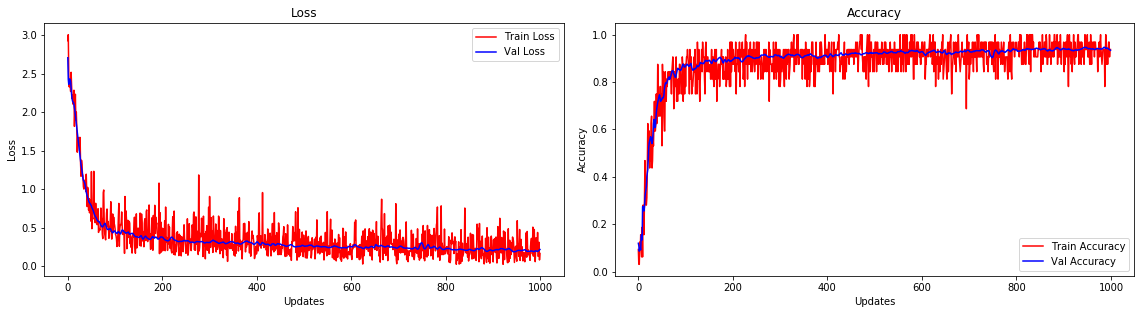

In [19]:
### YOUR CODE HERE ###

## Plotting
fig = plt.figure(figsize=(16,12))
epoch = np.arange(len(train_cost))

# 1) Plot train and validation loss as a function of time

fig.add_subplot(325)
plt.title('Loss')
plt.plot(epoch, train_cost,'r', label='Train Loss')
plt.plot(epoch, val_cost,'b', label='Val Loss')
plt.legend()
plt.xlabel('Updates'), plt.ylabel('Loss')

# 2) Plot train and validation accuracy as a function of time

fig.add_subplot(326)
plt.title('Accuracy')
plt.plot(epoch, train_acc,'r', label='Train Accuracy')
plt.plot(epoch, val_acc,'b', label='Val Accuracy')
plt.legend(loc=4)
plt.xlabel('Updates'), plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()

We can then compute the error on the test set and the confusion matrix is also obtained.

In [20]:
with tf.Session(config=tf.ConfigProto(gpu_options=gpu_opts)) as sess:    
    saver.restore(sess, './mnist_network_elu')
    feed_dict_valid = {x_pl: mnist_data.test.images, y_pl: mnist_data.test.labels}

    # deciding which parts to fetch
    fetches_valid = [accuracy]          

    # running the validation
    test_acc = sess.run(fetches=fetches_valid, feed_dict=feed_dict_valid)
    
    y_pred = pred(mnist_data.test.images, sess)    # Get predictions
    
    y_pred_1 = np.zeros_like(y_pred) # Make new matrix to contain one-hot encoded values of y_pred
    y_pred_1[np.arange(len(y_pred)), y_pred.argmax(1)] = 1 # Sets max to 1 and everything else to 0.

INFO:tensorflow:Restoring parameters from ./mnist_network_elu


We can then get the confusion matrix.

In [21]:
# .argmax(1) converts one hot to classes again
print(confusion_matrix(mnist_data.test.labels.argmax(1), y_pred_1.argmax(1))) 

[[ 966    0    1    1    0    3    7    2    0    0]
 [   0 1122    2    1    1    1    4    2    2    0]
 [  14   22  946   13   10    1   14    7    5    0]
 [   2    5   13  928    4   33    1   11    7    6]
 [   1    0    4    0  948    0   16    2    2    9]
 [   6    6    4    9    7  834   15    5    3    3]
 [   8    3    0    1    6   21  919    0    0    0]
 [   2   10   19    4   12    1    0  965    1   14]
 [  11   23    8   30   12   42   20   16  811    1]
 [  12    4    2   12   84    9    1   19    3  863]]


And the test accuracy

In [22]:
print('The test accuracy using elu is {}'.format(test_acc))

The test accuracy using elu is [0.93020016]


### Image Examples

I now take the first 4 images, and see how the classifier works on these.

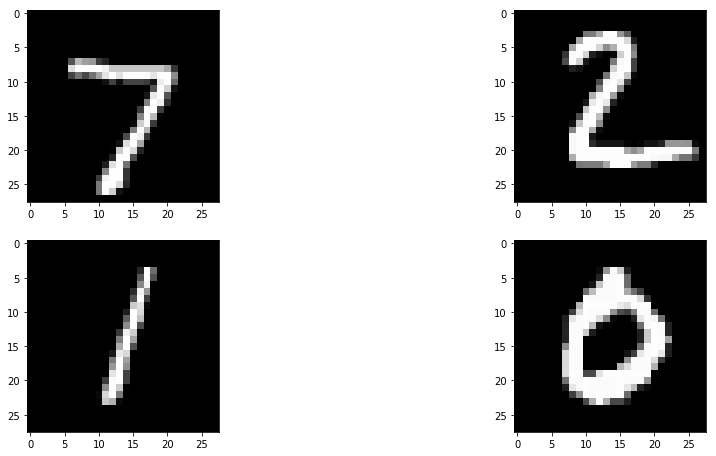

In [23]:
# 3) Select some random validation images, visualize them, and examine the output of the network.

fig = plt.figure(figsize=(16,12))
image = mnist_data.test.images[0]
fig.add_subplot(321)    
plt.imshow(np.reshape(image,[28,28]), interpolation="nearest", cmap="gray")

image = mnist_data.test.images[1]
fig.add_subplot(322)    
plt.imshow(np.reshape(image,[28,28]), interpolation="nearest", cmap="gray")

image = mnist_data.test.images[2]
fig.add_subplot(323)    
plt.imshow(np.reshape(image,[28,28]), interpolation="nearest", cmap="gray")

image = mnist_data.test.images[3]
fig.add_subplot(324)    
plt.imshow(np.reshape(image,[28,28]), interpolation="nearest", cmap="gray")

In [24]:
with tf.Session(config=tf.ConfigProto(gpu_options=gpu_opts)) as sess:    
    saver.restore(sess, './mnist_network_elu')
    for i in range(0,4):
        res = pred([mnist_data.test.images[i]], sess)
        print(np.argmax(res))

INFO:tensorflow:Restoring parameters from ./mnist_network_elu
7
2
1
0


Sp there are no missclassifications for the first 4 images.

We could then try to find some misclassifications.

In [39]:
with tf.Session(config=tf.ConfigProto(gpu_options=gpu_opts)) as sess:    
    saver.restore(sess, './mnist_network_elu')
    for i in range(0, 250):
        res = pred([mnist_data.test.images[i]], sess)
        if np.argmax(mnist_data.test.labels[i]) != np.argmax(res):
            print(i)

INFO:tensorflow:Restoring parameters from ./mnist_network_elu
8
33
92
124
125
149
193
217
233
241
245
247
249


I now display some of these

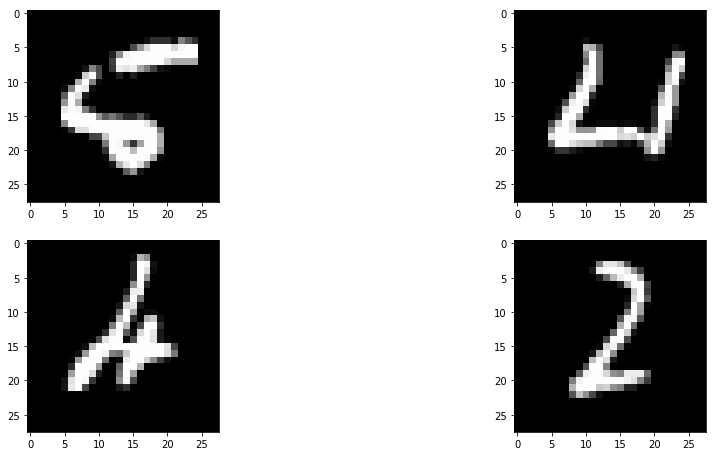

In [40]:
fig = plt.figure(figsize=(16,12))
image = mnist_data.test.images[8]
fig.add_subplot(321)    
plt.imshow(np.reshape(image,[28,28]), interpolation="nearest", cmap="gray")

image = mnist_data.test.images[33]
fig.add_subplot(322)    
plt.imshow(np.reshape(image,[28,28]), interpolation="nearest", cmap="gray")

image = mnist_data.test.images[247]
fig.add_subplot(323)    
plt.imshow(np.reshape(image,[28,28]), interpolation="nearest", cmap="gray")

image = mnist_data.test.images[249]
fig.add_subplot(324)    
plt.imshow(np.reshape(image,[28,28]), interpolation="nearest", cmap="gray")

And see what the network thinks

In [41]:
with tf.Session(config=tf.ConfigProto(gpu_options=gpu_opts)) as sess:    
    saver.restore(sess, './mnist_network_elu')
    for i in [8, 33, 247, 249]:
        res = pred([mnist_data.test.images[i]], sess)
        print("Network output = {}. True output {}".format(np.argmax(res), np.argmax(mnist_data.test.labels[i])))

INFO:tensorflow:Restoring parameters from ./mnist_network_elu
Network output = 6. True output 5
Network output = 6. True output 4
Network output = 6. True output 4
Network output = 1. True output 2


For the first misclassification, the network thinks it's a 6, probably because it has the distict arch at the top.

For the misclassification of the 4, the network believes it is a 6. This one would maybe even be hard for some humans, it looks like the writer did not finish the final stroke.

For the misclassification of the other 4, this may also be very hard for a human, it hardly looks like a number.

For the misclassification of 2, the number is very narrow, and sometimes people will write the number 1 with a horizontal line at the bottom and at the top like this 1.

We can look a little closer at what the network thinks by printing the output at each output neuron for the last example, the misclassification of 2 as a 1.

In [44]:
with tf.Session(config=tf.ConfigProto(gpu_options=gpu_opts)) as sess:    
    saver.restore(sess, './mnist_network_elu')
    res = pred([mnist_data.test.images[249]], sess)
    print(res)

INFO:tensorflow:Restoring parameters from ./mnist_network_elu
[[  1.48563258e-05   5.54961205e-01   4.23027486e-01   7.08698854e-03
    4.16311110e-07   1.50656968e-04   1.39576038e-02   4.13718908e-06
    7.96564214e-04   1.93189056e-08]]


So the output neurons with the highest probability are those for 1 and 2, in that order. So 2 does have a high probability, and the network does recognize features of the number.

## Book Exercise: Sigmoid neurons simulating perceptrons, part I 

### Description

Suppose we take all the weights and biases in a network of perceptrons, and multiply them by a positive constant, $c>0$. Show that the behaviour of the network doesn't change.

### Solution

The output is given as

\begin{equation}
    \mbox{output} = \begin{cases}
    0 & \mbox{if } \sum_j w_j x_j \leq \mbox{threshold} \\
    1 & \mbox{if } \sum_j w_j x_j > \mbox{threshold} \\    
    \end{cases}
\end{equation}

with $b \equiv - \mbox{threshold}$.

If we multiply all the weights and the biases with $c$, we get

\begin{equation}
    \mbox{output} = \begin{cases}
    0 & \mbox{if } c\sum_j w_j x_j \leq c \cdot \mbox{threshold} \\
    1 & \mbox{if } c\sum_j w_j x_j > c \cdot \mbox{threshold} \\    
    \end{cases}
\end{equation}

This is the same as before we multiplied with $c$, since we in the above expression can just divide with $c$ on both sides of the inequality, and we then obtain the original expression.

## Book Exercise: Sigmoid neurons simulating perceptrons, part II

### Description

Suppose we have the same setup as the last problem - a network of perceptrons. 
Suppose also that the overall input to the network of perceptrons has been chosen. 
We won't need the actual input value, we just need the input to have been fixed. 
Suppose the weights and biases are such that $w \cdot x + b \neq 0$ for the input $x$ to any particular perceptron in the network.
Now replace all perceptrons in the network by sigmoid neurons, and multiply the weights and biases by a positive constant $c>0$.
Show that in the limit as $c \rightarrow \infty$ the behaviour of this network of sigmoid neurons is exactly the same as the network of perceptrons.
How can this fail when $w \cdot x + b = 0$ for one of the perceptrons?

### Solution

The sigmoid function is given as

\begin{equation}
    \sigma(z) = \frac{1}{1+e^{-z}}
\end{equation}

where $z = w \cdot x + b$.
Multiplying the weights and biases with $c$ gives us $c \cdot (w \cdot x + b) = cz$, since $w$ and $b$ occur in both terms.

In the limit $c \rightarrow \infty$ we get that

\begin{equation}
    \sigma(cz) \rightarrow \pm 1 \quad \mbox{for } \pm z
\end{equation}

As $c$ goes towards infinity, we essentially push $\sigma$ to the edges as we have $cz \rightarrow \pm \infty$, the sign of $z$ then determines if the output is 0 or 1.

Below, I plot the sigmoid function for illustratory purposes

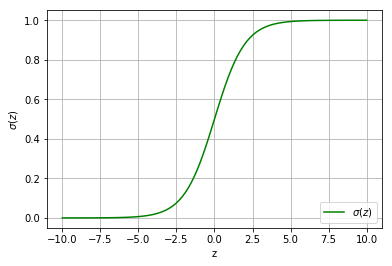

In [72]:
sigmoid = lambda x: 1 / (1 + np.exp(-x))
y=np.linspace(-10,10,100)
plt.plot(y,sigmoid(y),'g', label = '$\sigma(z)$')
plt.grid()
plt.xlabel('z')
plt.ylabel('$\sigma(z)$')
plt.legend(loc='lower right')

If $z=0$ then 

\begin{equation}
    \sigma(0) = \frac{1}{1+e^{-0}} = \frac{1}{2}
\end{equation}

So in this case, the network behaviour is different from that of the perceptron, since we get $\frac{1}{2}$ and not 0 or 1.

# Closing Remarks

You have now seen several different ways in which feed forward neural networks can be created.
There is no "right" way to define a neural network.
Ideally you should be able to understand how to implement everything at a low-level, and use high-level APIs to reduce human error and speedup development.
There are numerous frameworks which takes care the fundamental concepts are implemented correctly.
In this class we will mostly use Tensorflow and show Keras implementations here and there.
There are however alternatives that each have their strenghts and weaknesses: 
- [Pytorch](http://pytorch.org/)
- [Theano](http://deeplearning.net/software/theano/)
- [CNTK](https://github.com/Microsoft/CNTK)
- [Chainer](https://github.com/chainer/chainer)
- ... etc.

There is no framework that is "better" than the others.
However, each has their particular focus.
Keras tries to be the easiest to use and takes the most "High-level" approach to Deep Learning.
This might be useful at times, however, at others you might want to have more flexibility than such a High-level framework can provide. 

As you will see, FFNs are just one of many types of architectures and from here we will take a look at the extremely useful alternative called Convolutional Neural Networks. 